In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sy
import time
from pycqed import *

def diff2(sweep, dep, ind, var={}):
    xy, z, v = hamil.getSweep(sweep, [dep, ind], var)
    ret = []
    for i in range(len(xy[1])):
        ret.append(np.gradient(np.gradient(z[0,i,:],xy[0][1]-xy[0][0],edge_order=2),xy[0][1]-xy[0][0],edge_order=2)[1])
    return np.array(ret)

# Averin Coupler Study

Here we simulate the the [Averin coupler circuit](https://arxiv.org/abs/cond-mat/0304166) for creating a variable electrostatic coupling between qubits. First we look at the isolated coupler and compare with the results presented in Averin's paper.

## Isolated Coupler

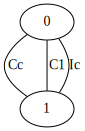

In [2]:
graph = CircuitGraph()
graph.addBranch(0, 1, "Cc")
graph.addBranch(0, 1, "C1")
graph.addBranch(0, 1, "Ic")
graph.addChargeBias(1, "Cg1")
graph.drawGraphViz()

The capacitance $C_1$ is included to account for any capacitive loading by external circuits, including stray capacitance to the island. $C_{g1}$ represents the gate capacitance, but it could be lumped into $C_1$.

The circuit Hamiltonian here is as follows:

In [3]:
circuit = SymbolicSystem(graph)
circuit.getQuantumHamiltonian()

Optimal basis representations for the circuit coordinates:
{1: 'charge'}


Matrix([[-0.5*I_{c}*(D^{\dagger}_{1} + D_{1}) + 0.5*(Q_{1e} + Q_{1})**2/C_{00}]])

The charging energy at node 1 is:

In [4]:
Ec = circuit.getSingleParticleChargingEnergies()[1]
display(Ec)

2.0*e**2/C_{00}

The Josephson energy of the single JJ is:

In [5]:
Ej = circuit.getJosephsonEnergies()[(0, 1, 2)]
display(Ej)

I_{c}*\Phi_0/(2*pi)

We know from Averin _et al_ that to maximize the electrostatic coupling, we need to maximize the ratio of the charging energy to the Josephson energy, this can the be expressed as:

In [6]:
display(Ec/Ej)

4.0*pi*e**2/(C_{00}*I_{c}*\Phi_0)

Where it is clear that both the junction critical current and all the capacitances have to be minimized.

Now we express the degrees of freedom of the circuit in the charge basis, since there are no inductors we cannot use an oscillator basis. We can use a high truncation for the single mode since it is not demanding computationally:

In [7]:
hamil = NumericalSystem(circuit)
hamil.configureOperator(1, 20, "charge")
hamil.getParameterNames()

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


['Cc', 'C1', 'Ic', 'Cg1', 'Q1e', 'C00']

Now we set the circuit parameter values and determine the Hamiltonian at half a Cooper pair charge:

In [8]:
# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 2.0  # uA/um^2
Aj = 0.15*0.1#0.4**2 # um^2

# Parameter initial values
hamil.setParameterValues(
    "Cc", Ca*Aj,
    "Ic", Jc*Aj,
    "C1", 0.5,
    "Cg1", 5,
    "Q1e", 0.5
)

In [9]:
H = hamil.getHamiltonian()
display(H)

Quantum object: dims = [[41], [41]], shape = (41, 41), type = oper, isherm = True
Qobj data =
[[5087.7117916    -7.45025272    0.         ...    0.
     0.            0.        ]
 [  -7.45025272 4603.45605891   -7.45025272 ...    0.
     0.            0.        ]
 [   0.           -7.45025272 4143.41311285 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... 3707.58295343
    -7.45025272    0.        ]
 [   0.            0.            0.         ...   -7.45025272
  4143.41311285   -7.45025272]
 [   0.            0.            0.         ...    0.
    -7.45025272 4603.45605891]]

The minimum gap is just the difference between the first excited and ground states:

In [10]:
E = H.eigenenergies()
E[1]-E[0]

13.6594438944588

Here we see that the minimum energy gap is high enough to not interact significantly with flux qubits used in QA, which typically are operated with energy scales under 10 GHz.

Now we look at the energy spectrum as a function of the external gate charge, induced through the gate capacitance $C_{g1}$. During the sweep we can evaluate the charging energy of node 1 and the Josephson energy of the junction on branch (0,1):

In [11]:
# Configure the sweep
hamil.newSweep()
hamil.addSweep('Ic', Jc*Aj/2, Jc*Aj*2, 4)
hamil.addSweep('Q1e', -1.0, 1.0, 101)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('ChargingEnergy', node=1)
hamil.addEvaluation('JosephsonEnergy', edge=(0, 1, 2))

sweep = hamil.paramSweep(timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.009 s
  Loop duration:	2.224 s
  Avg iteration:	0.006 s


Now lets plot the energy gap spectrum and the ground state side-by-side:

Text(0.5, 1.0, 'Ground State')

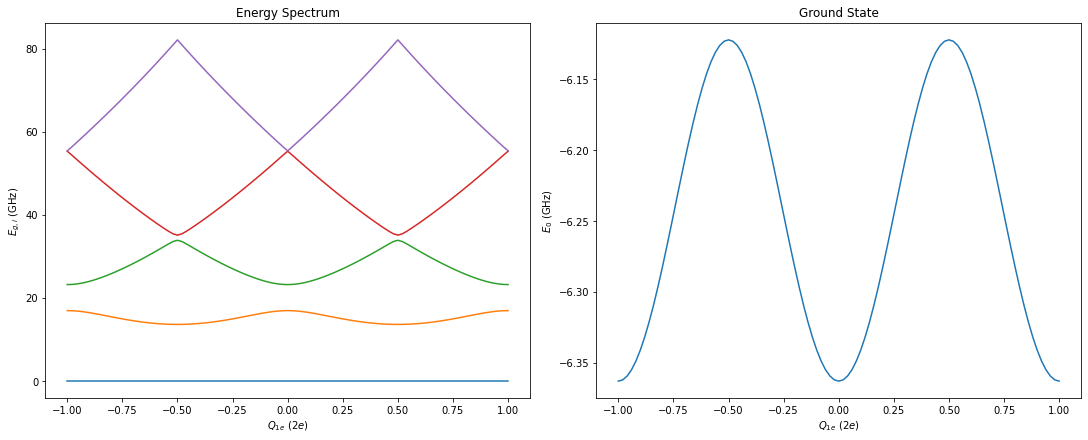

In [12]:
# Get the sweep for a high value of Ic
x,Q1e_sweep,v = hamil.getSweep(sweep, 'Q1e', {'Ic':Jc*Aj})

fig, ax = plt.subplots(ncols=2,nrows=1,constrained_layout=True,figsize=(15,6))
ax1 = ax[0]
ax2 = ax[1]

# Energy spectrum
for i in range(5):
    y = Q1e_sweep[i]-Q1e_sweep[0]
    ax1.plot(x,y)
ax1.set_xlabel("$Q_{1e}$ ($2e$)")
ax1.set_ylabel("$E_{g,i}$ (GHz)")
ax1.set_title("Energy Spectrum")

# Ground state
y = Q1e_sweep[0]
ax2.plot(x,y)
ax2.set_xlabel("$Q_{1e}$ ($2e$)")
ax2.set_ylabel("$E_{0}$ (GHz)")
ax2.set_title("Ground State")

As can be seen, the ground state energy varies very little, and thus the variation in the coupling energy will be very small. Let's now look at the ratio between the charging energy and Josephson energy:

In [13]:
# Get the sweep for a single value of flux
x, Ec_sweep, v = hamil.getSweep(sweep, 'Ic', {'Q1e': 0.5}, evaluable="ChargingEnergy")
x, Ej_sweep, v = hamil.getSweep(sweep, 'Ic', {'Q1e': 0.5}, evaluable="JosephsonEnergy")

In [14]:
EcEj = Ec_sweep/Ej_sweep
EcEj

array([1.62496411, 0.81248206, 0.5416547 , 0.40624103])

Indeed we see that for a small ratio, the ground state should have an almost sinusoidal shape as observed.

Now if we plot the second derivative of the ground state against the gate charge, we can compare the results quantitavely:

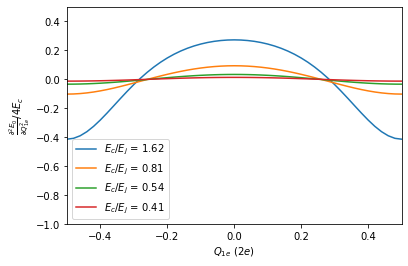

In [15]:
# Get the sweep
for i, Ic in enumerate(hamil.getParameterSweep('Ic')):
    x, y, v = hamil.getSweep(sweep, 'Q1e', {'Ic': Ic})
    dy = np.gradient(np.gradient(y[0], x[1]-x[0], edge_order=2), x[1]-x[0], edge_order=2)/(Ec_sweep[i]*4)
    plt.plot(x, dy, label="$E_c/E_j$ = %.2f" % (EcEj[i]))
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$\\frac{\\partial^2 E_{0}}{\\partial Q_{1e}^2} / 4E_c$")
plt.xlim(-0.5, 0.5)
plt.ylim(-1.0, 0.5)
plt.legend()

We find that the coupling strength roughly matches that presented in FIG. 3 of Averin's paper.

We see that for a large ratio of $E_c$ to $E_j$, we can get a coupling strength that approaches the order of magnitude of the charging energy.

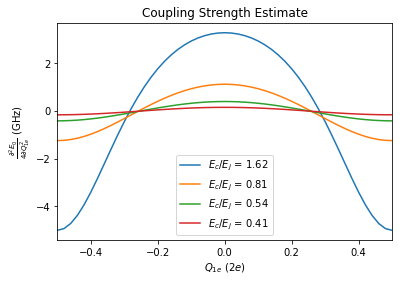

In [16]:
# Get the sweep
for i, Ic in enumerate(hamil.getParameterSweep('Ic')):
    x, y, v = hamil.getSweep(sweep, 'Q1e', {'Ic': Ic})
    dy = np.gradient(np.gradient(y[0], x[1]-x[0], edge_order=2)/4, x[1]-x[0], edge_order=2)
    plt.plot(x, dy, label="$E_c/E_j$ = %.2f" % (EcEj[i]))
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ ($\\mathrm{GHz}$)")
plt.xlim(-0.5,0.5)
plt.title("Coupling Strength Estimate")
#plt.ylim(-1.0,0.5)
plt.legend()

This implies that huge coupling energies can be achieved, however in practice there will many more capacitances connected to node 1, which will significantly decrease this energy, and in turn require the Josephson energy to decrease also.

Now lets look at the coupler minimum gap as a function of this ratio:

In [17]:
# Configure the sweep
hamil.newSweep()
hamil.addSweep('Ic',Jc*Aj*0.1,Jc*Aj*10,100)
hamil.addSweep('C1',0,10,3)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('ChargingEnergy', node=1)
hamil.addEvaluation('JosephsonEnergy', edge=(0,1,2))

# Set some parameters
hamil.setParameterValue('Q1e', 0.5)

sweep = hamil.paramSweep(timesweep=True)

# Get the sweep for a single value of flux
x,Ec_sweep1,v = hamil.getSweep(sweep,'Ic',{'C1':0},evaluable="ChargingEnergy")
x,Ej_sweep1,v = hamil.getSweep(sweep,'Ic',{'C1':0},evaluable="JosephsonEnergy")
x,Ec_sweep2,v = hamil.getSweep(sweep,'Ic',{'C1':5},evaluable="ChargingEnergy")
x,Ej_sweep2,v = hamil.getSweep(sweep,'Ic',{'C1':5},evaluable="JosephsonEnergy")
x,Ec_sweep3,v = hamil.getSweep(sweep,'Ic',{'C1':10},evaluable="ChargingEnergy")
x,Ej_sweep3,v = hamil.getSweep(sweep,'Ic',{'C1':10},evaluable="JosephsonEnergy")

# Get energy ratio
EcEj1 = Ec_sweep1/Ej_sweep1
EcEj2 = Ec_sweep2/Ej_sweep2
EcEj3 = Ec_sweep3/Ej_sweep3

# Get the sweep for a high value of Ic
x,Ic_sweep1,v = hamil.getSweep(sweep,'Ic',{'C1':0})
x,Ic_sweep2,v = hamil.getSweep(sweep,'Ic',{'C1':5})
x,Ic_sweep3,v = hamil.getSweep(sweep,'Ic',{'C1':10})

Parameter Sweep Duration:
  Initialization:	0.007 s
  Loop duration:	1.602 s
  Avg iteration:	0.005 s


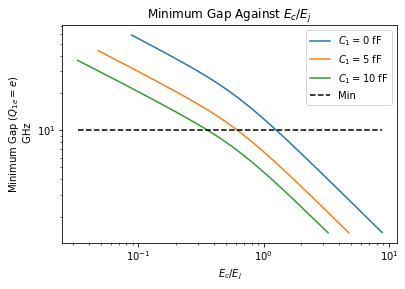

In [18]:
plt.plot(EcEj1,Ic_sweep1[1]-Ic_sweep1[0],label="$C_1 = 0$ fF")
plt.plot(EcEj2,Ic_sweep2[1]-Ic_sweep2[0],label="$C_1 = 5$ fF")
plt.plot(EcEj3,Ic_sweep3[1]-Ic_sweep3[0],label="$C_1 = 10$ fF")
plt.plot([EcEj3[-1],EcEj1[0]],[10,10],"k--",label="Min")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$E_c/E_j$')
plt.ylabel('Minimum Gap ($Q_{1e}=e$)\n GHz')
plt.title('Minimum Gap Against $E_c/E_j$')
plt.legend(loc=1)

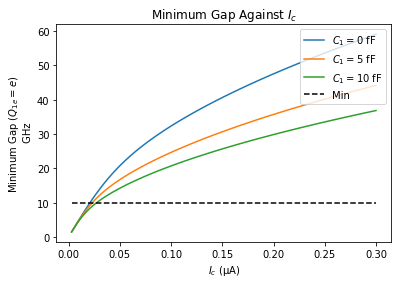

In [19]:
plt.plot(x,Ic_sweep1[1]-Ic_sweep1[0],label="$C_1 = 0$ fF")
plt.plot(x,Ic_sweep2[1]-Ic_sweep2[0],label="$C_1 = 5$ fF")
plt.plot(x,Ic_sweep3[1]-Ic_sweep3[0],label="$C_1 = 10$ fF")
plt.plot([x[0],x[-1]],[10,10],"k--",label="Min")
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$I_c$ ($\\mathrm{\mu A}$)')
plt.ylabel('Minimum Gap ($Q_{1e}=e$)\n GHz')
plt.title('Minimum Gap Against $I_c$')
plt.legend(loc=1)

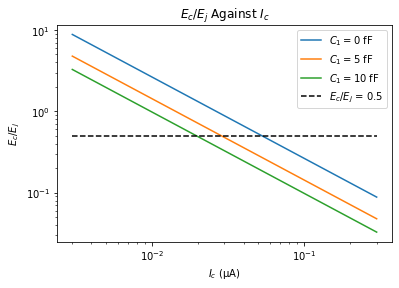

In [20]:
plt.plot(x,EcEj1,label="$C_1 = 0$ fF")
plt.plot(x,EcEj2,label="$C_1 = 5$ fF")
plt.plot(x,EcEj3,label="$C_1 = 10$ fF")
plt.plot([x[0],x[-1]],[0.5,0.5],"k--",label="$E_c/E_j$ = 0.5")
plt.plot([])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$I_c$ ($\\mathrm{\mu A}$)')
plt.ylabel('$E_c/E_j$')
plt.title('$E_c/E_j$ Against $I_c$')
plt.legend(loc=1)

## Coupler Fabrication Parameters

Now we can consider what we encounter in practice, by expressing the various circuit parameters in terms of fabrication parameters.

In [21]:
# Create new symbols
sym = hamil.getSymbolicSystem().getSymbols("Jc", "Ca", "wse", "w1")

# Replace capacitors
hamil.getSymbolicSystem().addParameterisation("Cc", sym["wse"]*sym["w1"]*sym["Ca"])

# Replace JJs
hamil.getSymbolicSystem().addParameterisation("Ic", sym["wse"]*sym["w1"]*sym["Jc"])

In [22]:
hamil.getSymbolicSystem().getParametricExpression('Ic')

J_{c}*w_{1}*w_{se}

Now lets sweep some of the circuit parameters that are critical to the coupling strength, we can first look at the dependence of the coupling strength near half a Cooper pair bias:

In [23]:
hamil.setParameterValues(
    'wse', 0.1,
    'w1', 0.15,
    'Ca', 60,
    'Jc', 3,
    'Cg1', 1.0,
    'C1', 10,
    'Q1e', 0.5
)

hamil.newSweep()
hamil.addSweep('Q1e', 0.499, 0.501, 3) # We need these points to take the derivative
hamil.addSweep('C1', 3, 17, 4)
hamil.addSweep('Jc', 0.1, 10.0, 101)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('ChargingEnergy', node=1)
hamil.addEvaluation('JosephsonEnergy', edge=(0,1,2))
sweep = hamil.paramSweep(timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.009 s
  Loop duration:	9.000 s
  Avg iteration:	0.007 s


In [24]:
print ("Cc = %.3f fF" % (hamil.getParameterValue('Cc')))

Cc = 0.900 fF


In [25]:
# Take the second derivative of ground state against Jc and l1 points
Cpl_e = []
for l1 in hamil.getParameterSweep('C1'):
    xy, z, v = hamil.getSweep(sweep, ['Jc', 'Q1e'], {'C1': l1})
    Cpl1 = []
    for i in range(len(xy[1])):
        Cpl1.append(np.gradient(np.gradient(z[0,i,:],xy[0][1]-xy[0][0],edge_order=2),xy[0][1]-xy[0][0],edge_order=2)[1])
    Cpl_e.append(np.array(Cpl1))

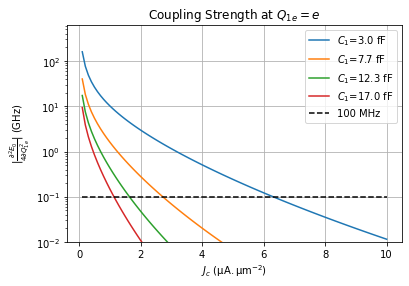

In [26]:
plt.title("Coupling Strength at $Q_{1e} = e$")
for i,Cpl1 in enumerate(Cpl_e):
    plt.plot(xy[1],np.abs(Cpl1)/4,label="$C_1$=%.1f fF" % (hamil.getParameterSweep('C1')[i]))
plt.plot([xy[1][0],xy[1][-1]],[0.1,0.1],"k--",label="100 MHz")
plt.yscale('log')
plt.xlabel("$J_c$ $(\\mathrm{\mu A.\mu m^{-2}})$")
plt.ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)")
plt.ylim((0.01,abs(Cpl_e[0][0])))
plt.legend()
plt.grid()

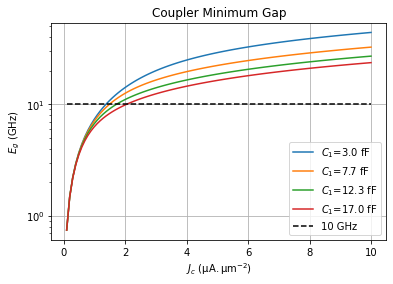

In [27]:
# Take the second derivative of ground state against Jc and l1 points
Gap_e = []
for l1 in hamil.getParameterSweep('C1'):
    x, z, v = hamil.getSweep(sweep,'Jc',{'C1':l1,'Q1e':0.5})
    Gap_e.append(np.array(z[1]-z[0]))

plt.title("Coupler Minimum Gap")
for i,l1 in enumerate(hamil.getParameterSweep('C1')):
    plt.plot(x,Gap_e[i],label="$C_{1}$=%.1f fF" % (l1))
plt.plot([x[0],x[-1]],[10,10],"k--",label="10 GHz")
plt.yscale('log')
plt.xlabel("$J_c$ $(\\mathrm{\mu A.\mu m^{-2}})$")
plt.ylabel("$E_g$ (GHz)")
plt.legend()
plt.grid()

### Regions of Interest

We can plot both the coupler strength and minimum gap on the same plot to define a region of interest. The idea is to maximise the coupling strength whilst maintaining a high enough minimum gap to avoid interfering with the computational subspace in a qubit system that uses this coupler.

We therefore set two conditions that must be simultaneously satisfied:
- The minimum acceptable coupling strength is 100 MHz
- The minimum gap cannot go below 10 GHz

__The black dotted line represents both conditions above.__

__As long as the intercept of like-coloured lines is above the black dotted line, there exists a region of interest for the parameter of the X-axis.__

__The coupler gap curves are represented by dashed lines.__

__The maximum coupling achievable is that found at the parameter value for which the (dashed) coupler gap curve intersects the black dotted line.__

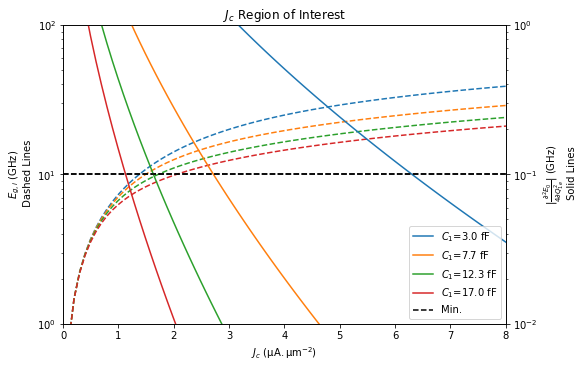

In [28]:
fig, ax1 = plt.subplots(ncols=1,nrows=1,constrained_layout=True,figsize=(8,5))
xran = (0,8)

# Energy spectrum
ax1.plot(x,Gap_e[0],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax1.plot(x,Gap_e[1],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax1.plot(x,Gap_e[2],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax1.plot(x,Gap_e[3],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax1.plot(xran,[10,10],"k--")
ax1.set_xlabel("$J_c$ $(\\mathrm{\mu A.\mu m^{-2}})$")
ax1.set_ylabel("$E_{g,i}$ (GHz)\n Dashed Lines")
ax1.set_title("$J_c$ Region of Interest")
ax1.set_yscale('log')
ax1.set_ylim((1,100))

ax11 = ax1.twinx()
ax11.plot(x,np.abs(Cpl_e[0])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax11.plot(x,np.abs(Cpl_e[1])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax11.plot(x,np.abs(Cpl_e[2])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax11.plot(x,np.abs(Cpl_e[3])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax11.plot(xran,[0.1,0.1],"k--",label="Min.")
ax11.set_ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)\n Solid Lines")
ax11.set_yscale('log')
ax11.set_ylim((1e-2,1))
ax1.set_xlim(xran)
ax11.legend(loc=4)

In [29]:
x,Ec_sweep1,v = hamil.getSweep(sweep,'Jc',{'C1':3,'Q1e':0.5},evaluable="ChargingEnergy")
x,Ej_sweep1,v = hamil.getSweep(sweep,'Jc',{'C1':3,'Q1e':0.5},evaluable="JosephsonEnergy")
x,Ec_sweep2,v = hamil.getSweep(sweep,'Jc',{'C1':8,'Q1e':0.5},evaluable="ChargingEnergy")
x,Ej_sweep2,v = hamil.getSweep(sweep,'Jc',{'C1':8,'Q1e':0.5},evaluable="JosephsonEnergy")
x,Ec_sweep3,v = hamil.getSweep(sweep,'Jc',{'C1':12,'Q1e':0.5},evaluable="ChargingEnergy")
x,Ej_sweep3,v = hamil.getSweep(sweep,'Jc',{'C1':12,'Q1e':0.5},evaluable="JosephsonEnergy")
x,Ec_sweep4,v = hamil.getSweep(sweep,'Jc',{'C1':17,'Q1e':0.5},evaluable="ChargingEnergy")
x,Ej_sweep4,v = hamil.getSweep(sweep,'Jc',{'C1':17,'Q1e':0.5},evaluable="JosephsonEnergy")

# Get energy ratio
EcEj1 = Ec_sweep1/Ej_sweep1
EcEj2 = Ec_sweep2/Ej_sweep2
EcEj3 = Ec_sweep3/Ej_sweep3
EcEj4 = Ec_sweep4/Ej_sweep4

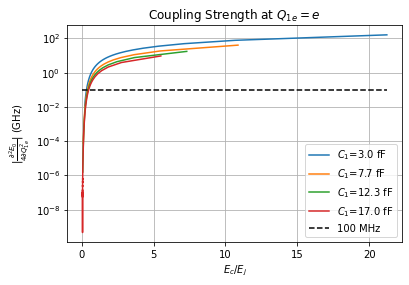

In [30]:
plt.title("Coupling Strength at $Q_{1e} = e$")
plt.plot(EcEj1,np.abs(Cpl_e[0])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
plt.plot(EcEj2,np.abs(Cpl_e[1])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
plt.plot(EcEj3,np.abs(Cpl_e[2])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
plt.plot(EcEj4,np.abs(Cpl_e[3])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
plt.plot([EcEj4[-1],EcEj1[0]],[0.1,0.1],"k--",label="100 MHz")
plt.yscale('log')
plt.xlabel("$E_c/E_j$")
plt.ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)")
#plt.ylim((0.01,abs(Cpl_e[0][0])))
plt.legend()
plt.grid()

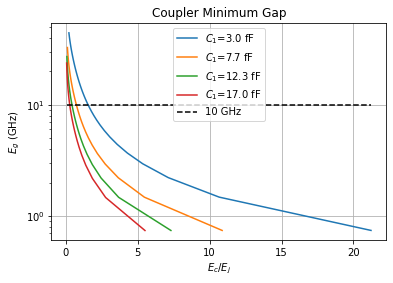

In [31]:
# Take the second derivative of ground state against Jc and l1 points
Gap_e = []
for l1 in hamil.getParameterSweep('C1'):
    x, z, v = hamil.getSweep(sweep,'Jc',{'C1':l1,'Q1e':0.5})
    Gap_e.append(np.array(z[1]-z[0]))

plt.title("Coupler Minimum Gap")
plt.plot(EcEj1,Gap_e[0],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
plt.plot(EcEj2,Gap_e[1],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
plt.plot(EcEj3,Gap_e[2],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
plt.plot(EcEj4,Gap_e[3],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
plt.plot([EcEj4[-1],EcEj1[0]],[10,10],"k--",label="10 GHz")
plt.yscale('log')
plt.xlabel("$E_c/E_j$")
plt.ylabel("$E_g$ (GHz)")
plt.legend()
plt.grid()

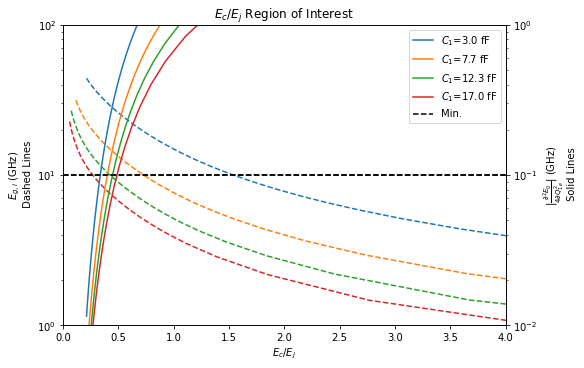

In [32]:
fig, ax1 = plt.subplots(ncols=1,nrows=1,constrained_layout=True,figsize=(8,5))
xran = (0,4)

# Energy spectrum
ax1.plot(EcEj1,Gap_e[0],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax1.plot(EcEj2,Gap_e[1],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax1.plot(EcEj3,Gap_e[2],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax1.plot(EcEj4,Gap_e[3],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax1.plot(xran,[10,10],"k--")
ax1.set_xlabel("$E_c/E_j$")
ax1.set_ylabel("$E_{g,i}$ (GHz)\n Dashed Lines")
ax1.set_title("$E_c/E_j$ Region of Interest")
ax1.set_yscale('log')
ax1.set_ylim((1,100))

ax11 = ax1.twinx()
ax11.plot(EcEj1,np.abs(Cpl_e[0])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax11.plot(EcEj2,np.abs(Cpl_e[1])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax11.plot(EcEj3,np.abs(Cpl_e[2])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax11.plot(EcEj4,np.abs(Cpl_e[3])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax11.plot(xran,[0.1,0.1],"k--",label="Min.")
ax11.set_ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)\n Solid Lines")
ax11.set_yscale('log')
ax11.set_ylim((1e-2,1))
ax1.set_xlim(xran)
ax11.legend(loc=0)

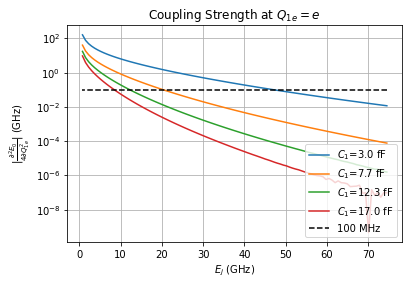

In [33]:
plt.title("Coupling Strength at $Q_{1e} = e$")
plt.plot(Ej_sweep1,np.abs(Cpl_e[0])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
plt.plot(Ej_sweep2,np.abs(Cpl_e[1])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
plt.plot(Ej_sweep3,np.abs(Cpl_e[2])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
plt.plot(Ej_sweep4,np.abs(Cpl_e[3])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
plt.plot([Ej_sweep3[-1],Ej_sweep1[0]],[0.1,0.1],"k--",label="100 MHz")
plt.yscale('log')
plt.xlabel("$E_j$ (GHz)")
plt.ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)")
#plt.ylim((0.01,abs(Cpl_e[0][0])))
plt.legend(loc=4)
plt.grid()

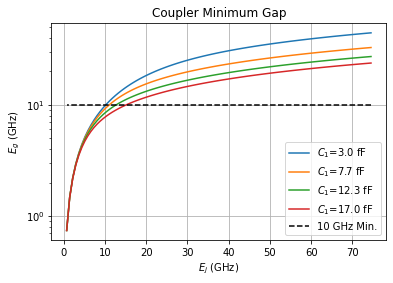

In [34]:
# Take the second derivative of ground state against Jc and l1 points
Gap_e = []
for l1 in hamil.getParameterSweep('C1'):
    x, z, v = hamil.getSweep(sweep,'Jc',{'C1':l1, 'Q1e':0.5})
    Gap_e.append(np.array(z[1]-z[0]))

plt.title("Coupler Minimum Gap")
plt.plot(Ej_sweep1,Gap_e[0],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
plt.plot(Ej_sweep2,Gap_e[1],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
plt.plot(Ej_sweep3,Gap_e[2],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
plt.plot(Ej_sweep4,Gap_e[3],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
plt.plot([Ej_sweep4[-1],Ej_sweep1[0]],[10,10],"k--",label="10 GHz Min.")
plt.yscale('log')
plt.xlabel("$E_j$ (GHz)")
plt.ylabel("$E_g$ (GHz)")
plt.legend()
plt.grid()

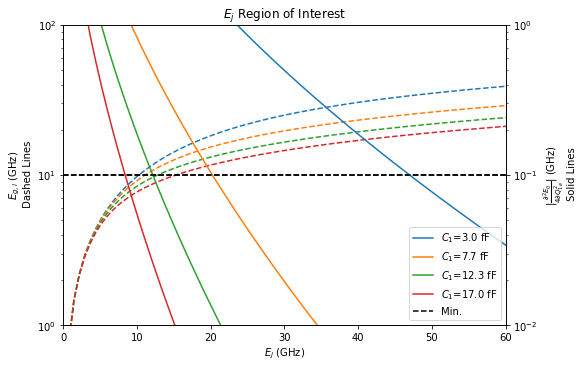

In [35]:
fig, ax1 = plt.subplots(ncols=1,nrows=1,constrained_layout=True,figsize=(8,5))
xran = (0,60)

# Energy spectrum
ax1.plot(Ej_sweep1,Gap_e[0],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax1.plot(Ej_sweep2,Gap_e[1],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax1.plot(Ej_sweep3,Gap_e[2],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax1.plot(Ej_sweep4,Gap_e[3],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax1.plot(xran,[10,10],"k--")
plt.xlabel("$E_j$ (GHz)")
ax1.set_ylabel("$E_{g,i}$ (GHz)\n Dashed Lines")
ax1.set_title("$E_j$ Region of Interest")
ax1.set_yscale('log')
ax1.set_ylim((1,100))

ax11 = ax1.twinx()
ax11.plot(Ej_sweep1,np.abs(Cpl_e[0])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax11.plot(Ej_sweep2,np.abs(Cpl_e[1])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax11.plot(Ej_sweep3,np.abs(Cpl_e[2])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax11.plot(Ej_sweep4,np.abs(Cpl_e[3])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax11.plot(xran,[0.1,0.1],"k--",label="Min.")
ax11.set_ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)\n Solid Lines")
ax11.set_yscale('log')
ax11.set_ylim((1e-2,1))
ax1.set_xlim(xran)
ax11.legend(loc=4)

## Tunable Junction

Now we select a range of parameters that are in the region of interest, and replace the single junction with a perfectly symmetric DC-SQUID.

In [36]:
# First remove the old parameterisation of the critical current
s = hamil.getSymbolicSystem()
s.rmParameterisation("Ic")

# Create new symbols
sym = s.getSymbols("phie", symbol_overrides=[sy.symbols("\\Phi_e")])

# Create the new parameterisation
expr = sy.cos(sy.pi*sym["phie"]) * s.getSymbol("Jc") * s.getSymbol("wse") * s.getSymbol("w1")
s.addParameterisation("Ic", expr)

In [37]:
s.getParametricExpression("Ic")

J_{c}*w_{1}*w_{se}*cos(pi*\Phi_e)

In [38]:
hamil.setParameterValues(
    'wse', 0.1,
    'w1', 0.15,
    'Ca', 60,
    'Jc', 1.5,
    'Cg1', 1,
    'C1', 7.7,
    'Q1e', 0.5,
    'phie', 0.0
)

# Configure the sweep
hamil.newSweep()
hamil.addSweep('Q1e',-1.0,1.0,101)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('ChargingEnergy', node=1)
hamil.addEvaluation('JosephsonEnergy', edge=(0,1,2))

sweep = hamil.paramSweep()

In [39]:
x, Q1e_sweep, v = hamil.getSweep(sweep, 'Q1e', {})

Text(0, 0.5, '$E_i$ (GHz)')

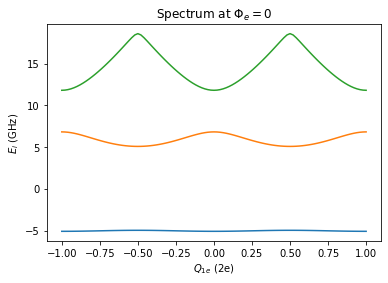

In [40]:
for i in range(3):
    plt.plot(x,Q1e_sweep[i]-Q1e_sweep[0]*0)
plt.title("Spectrum at $\Phi_e=0$")
plt.xlabel("$Q_{1e}$ (2e)")
plt.ylabel("$E_i$ (GHz)")

In [41]:
hamil.setParameterValues(
    'wse', 0.1,
    'w1', 0.15,
    'Ca', 60,
    'Jc', 1.5,
    'Cg1', 1,
    'C1', 7.7,
    'Q1e', 0.5,
    'phie', 0.5
)

# Configure the sweep
hamil.newSweep()
hamil.addSweep('Q1e',-1.0,1.0,101)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('ChargingEnergy', node=1)
hamil.addEvaluation('JosephsonEnergy', edge=(0,1,2))

sweep = hamil.paramSweep()

In [42]:
x,Q1e_sweep,v = hamil.getSweep(sweep,'Q1e',{})

Text(0, 0.5, '$E_i$ (GHz)')

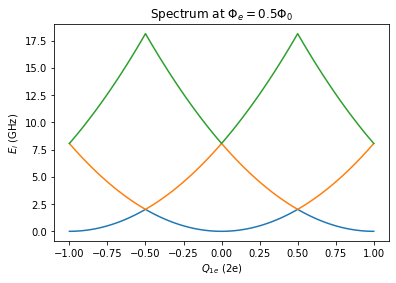

In [43]:
for i in range(3):
    plt.plot(x,Q1e_sweep[i]-Q1e_sweep[0]*0)
plt.title("Spectrum at $\Phi_e=0.5\Phi_0$")
plt.xlabel("$Q_{1e}$ (2e)")
plt.ylabel("$E_i$ (GHz)")

Ok lets look at the coupler strength and minimum gap as a function of the external flux:

In [44]:
hamil.setParameterValues(
    'wse', 0.1,
    'w1', 0.15,
    'Ca', 60,
    'Jc', 1.5,
    'Cg1', 1,
    'C1', 7.7,
    'Q1e', 0.5,
    'phie', 0.0
)

# Configure the sweep
hamil.newSweep()
hamil.addSweep('Q1e',0.4999,0.5001,3)
hamil.addSweep('phie',-0.5,0.5,201)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('ChargingEnergy', node=1)
hamil.addEvaluation('JosephsonEnergy', edge=(0,1,2))

sweep = hamil.paramSweep()

Text(0.5, 1.0, 'Coupling Strength at $Q_{1e} = e$')

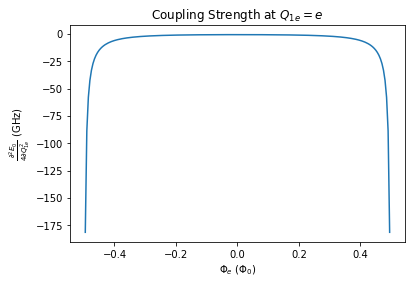

In [45]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = e$")

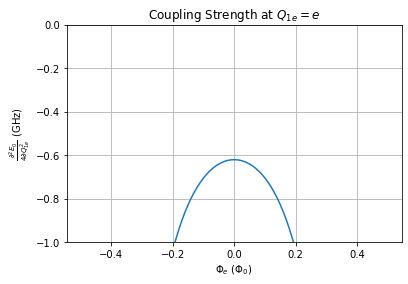

In [46]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = e$")
plt.ylim((-1,0))
plt.grid()

Text(0.5, 1.0, 'Coupler Energy Gaps at $Q_{1e}=e$')

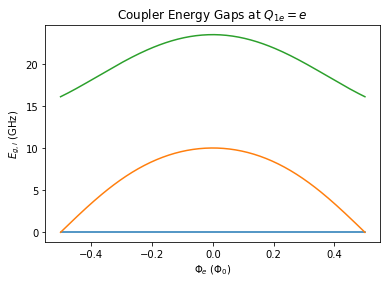

In [47]:
x,E,v = hamil.getSweep(sweep,'phie',{'Q1e':0.5})
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("Coupler Energy Gaps at $Q_{1e}=e$")

In [48]:
hamil.setParameterValues(
    'wse', 0.1,
    'w1', 0.15,
    'Ca', 60,
    'Jc', 1.5,
    'Cg1', 1,
    'C1', 7.7,
    'Q1e', 0.5,
    'phie', 0.0
)

# Configure the sweep
hamil.newSweep()
hamil.addSweep('Q1e',-0.0001,0.0001,3)
hamil.addSweep('phie',-0.5,0.5,201)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('ChargingEnergy', node=1)
hamil.addEvaluation('JosephsonEnergy', edge=(0,1,2))

sweep = hamil.paramSweep()

Text(0.5, 1.0, 'Coupling Strength at $Q_{1e} = 0$')

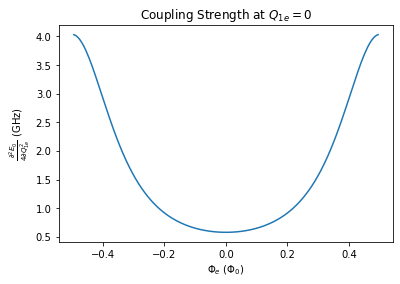

In [49]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = 0$")

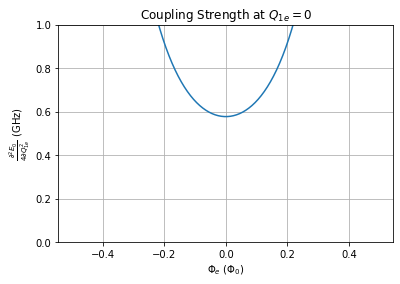

In [50]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = 0$")
plt.ylim((0,1))
plt.grid()

Text(0.5, 1.0, 'Coupler Energy Gaps at $Q_{1e}=e$')

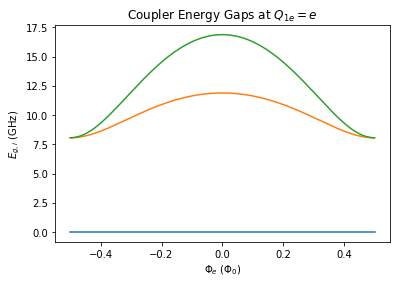

In [51]:
x,E,v = hamil.getSweep(sweep,'phie',{'Q1e':0.0})
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("Coupler Energy Gaps at $Q_{1e}=e$")

We see that the small $E_J$ we are aiming for now sets the minimum achievable coupling strength, which is a positive, but it now sets the maximum minimum-gap of the coupler spectrum, which is highly undesireable. Therefore the first thing to try is to increase $E_J$ to set a new minimum that is an acceptable turn-off point for the coupling term (i.e. at the beginning of the anneal).

In [52]:
hamil.setParameterValue('wse', 0.2)

# Configure the sweep
hamil.newSweep()
hamil.addSweep('Q1e',0.4999,0.5001,3)
hamil.addSweep('phie',-0.5,0.5,201)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('ChargingEnergy', node=1)
hamil.addEvaluation('JosephsonEnergy', edge=(0,1,2))

sweep = hamil.paramSweep()

Text(0.5, 1.0, 'Coupling Strength at $Q_{1e} = e$')

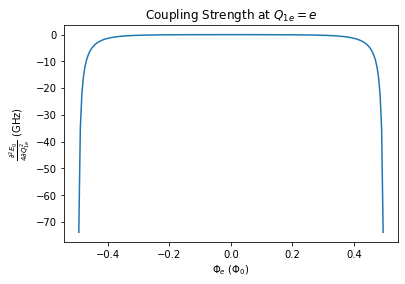

In [53]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = e$")

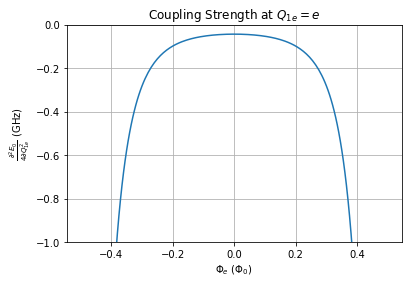

In [54]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = e$")
plt.ylim((-1,0))
plt.grid()

Text(0.5, 1.0, 'Coupler Energy Gaps at $Q_{1e}=e$')

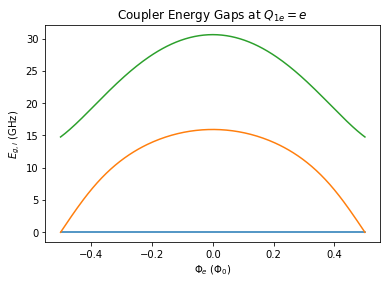

In [55]:
x,E,v = hamil.getSweep(sweep,'phie',{'Q1e':0.5})
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("Coupler Energy Gaps at $Q_{1e}=e$")

In [56]:
# Configure the sweep
hamil.newSweep()
hamil.addSweep('Q1e',-0.0001,0.0001,3)
hamil.addSweep('phie',-0.5,0.5,201)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('ChargingEnergy', node=1)
hamil.addEvaluation('JosephsonEnergy', edge=(0,1,2))

sweep = hamil.paramSweep()

Text(0.5, 1.0, 'Coupling Strength at $Q_{1e} = 0$')

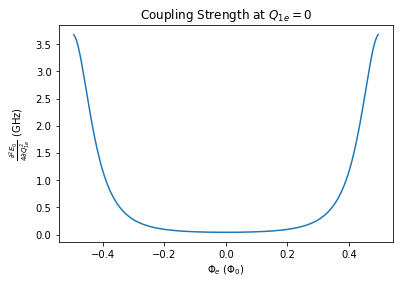

In [57]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = 0$")

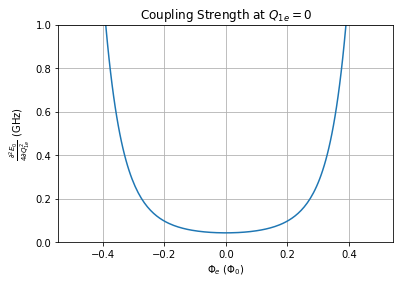

In [58]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = 0$")
plt.ylim((0,1))
plt.grid()

Text(0.5, 1.0, 'Coupler Energy Gaps at $Q_{1e}=0$')

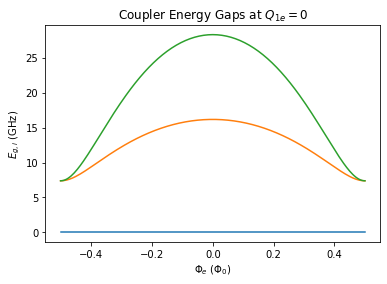

In [59]:
x,E,v = hamil.getSweep(sweep,'phie',{'Q1e':0.0})
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("Coupler Energy Gaps at $Q_{1e}=0$")

We see that by doubling the junction area, the maximum $E_J$ sets a minimum value of coupling energy close to zero. The flux would then need to be increased to a maximum value determined by the minimum gap condition, which also sets the maximum achievable coupling strength.

Although we have alleviated charge noise sensitivity, we have now introduced flux noise sensitivity due to the high slope at the ideal point described above. This can be mitigated by making the junction smaller, but decreases the on-off ratio as well as the minimum gap.

## Effect of Capacitively Coupled Resonator

Now we can observe what happens if we couple a linear resonator to the system, as a possible way to measure the variable capacitance of the Averin coupler.

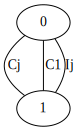

In [60]:
graph = CircuitGraph()
graph.addBranch(0, 1, "Cj")
graph.addBranch(0, 1, "C1")
graph.addBranch(0, 1, "Ij")
graph.addChargeBias(1, "Cg1")
graph.coupleResonatorCapacitively(1, "Cc")
graph.drawGraphViz()

We see the Hamiltonian is now more complicated:

In [61]:
circuit = SymbolicSystem(graph)
circuit.getQuantumHamiltonian()

Optimal basis representations for the circuit coordinates:
{1: 'charge'}


Matrix([[-0.5*I_{j}*(D^{\dagger}_{1} + D_{1}) + 0.5*(Q_{1e} + Q_{1})**2/C_{00}]])

### Single Junction Device

Since the capacitive loading effect of the resonator on the qubit will be significant, we effectively subtract the coupling capacitance value from $C_1$ to keep the device in the region of interest. This is a good approximation as long as the resonator capacitance is much larger than the coupling capacitance.

In [62]:
hamil = NumericalSystem(circuit)
hamil.configureOperator(1, 20, "charge")
s = hamil.getSymbolicSystem()

# Create new symbols
sym = s.getSymbols(
    "Jc", "Ca", "wse", "w1", "phie",
    symbol_overrides=[None, None, None, None, sy.symbols("\\Phi_e")]
)

# Replace capacitors
s.addParameterisation("Cj", sym["wse"]*sym["w1"]*sym["Ca"])

# Replace JJs
expr = sy.cos(sy.pi*sym["phie"]) * sym["Jc"] * sym["wse"] * sym["w1"]
s.addParameterisation("Ij", expr)

# Configure diagonaliser
hamil.setDiagConfig(get_vectors=True, eigvalues=20)

# Configure the sweep
hamil.newSweep()
hamil.addSweep('Q1e', -1, 1, 101)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('Resonator', cpl_node=1)

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


In [63]:
# Set the parameter values
hamil.setParameterValues(
    'wse',  0.1,
    'w1',   0.15,
    'Ca',   60,
    'Jc',   1.5,
    'Cg1',  1,
    'C1',   5.7,
    'f1r',  6.63156,
    'Z1r',  50.0,
    'Cc',   2.0,
    'Q1e',  0.0,
    'phie', 0.0
)

# Do the sweep
sweep = hamil.paramSweep()

In [64]:
hamil.SS.getSymbolValuesDict()

{C_{j}: 0.9,
 C_{1}: 5.7,
 I_{j}: 0.0225,
 C_{g1}: 1.0,
 Q_{1e}: 1.0,
 C_{c}: 2.0,
 f_{1r}: 6.63156,
 Z_{1r}: 50.0,
 C_{1r}: 479.9924696207086,
 L_{1r}: 1199.9811740517716,
 g_{1r}: 0.2150176464564355,
 f_{1rl}: 6.6206493451781805,
 Z_{1rl}: 49.91773689130598,
 C_{00}: 9.591701115158195,
 J_{c}: 1.5,
 C_{a}: 60.0,
 w_{se}: 0.1,
 w_{1}: 0.15,
 \Phi_e: 0.0}

First let's compare the bare spectrum vs the dressed spectrum:

In [65]:
x,EV,v = hamil.getSweep(sweep, 'Q1e', {}, evaluable='Hamiltonian')
E = EV[:,0]
V = EV[:,1]

Text(0.5, 1.0, 'Ground State')

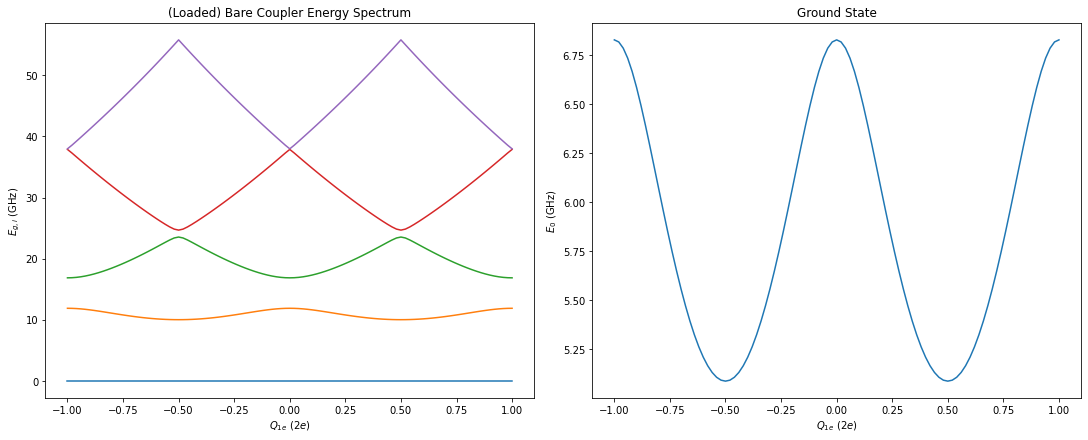

In [66]:
fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(15, 6))
ax1 = ax[0]
ax2 = ax[1]

# Energy spectrum
for i in range(5):
    y = E[i]-E[0]
    ax1.plot(x, y)
ax1.set_xlabel("$Q_{1e}$ ($2e$)")
ax1.set_ylabel("$E_{g,i}$ (GHz)")
ax1.set_title("(Loaded) Bare Coupler Energy Spectrum")

# Ground state
y = E[1]
ax2.plot(x, y)
ax2.set_xlabel("$Q_{1e}$ ($2e$)")
ax2.set_ylabel("$E_{0}$ (GHz)")
ax2.set_title("Ground State")

In [67]:
x,Erwa,v = hamil.getSweep(sweep,'Q1e',{},evaluable='Resonator')
Edressed = util.getCircuitLambShift(Erwa)

Text(0.5, 1.0, '(Loaded) Dressed Coupler Energy Spectrum')

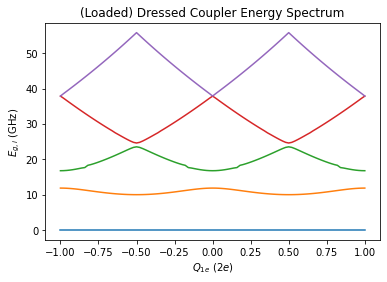

In [68]:
# Dressed energy spectrum
for i in range(5):
    y = Edressed[i]
    plt.plot(x,y)
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("(Loaded) Dressed Coupler Energy Spectrum")

We can see some evidence of coupler-resonator interaction in the second (green) energy gap, however the resonator likely lies in the tunneling gap, so we will not see an avoided crossing. We can observe more closely what is happening by solving the whole system later on.

Now let's get the resonator modulation:

In [69]:
# Get the design and loaded resonator frequencies
fr = hamil.getParameterValue('f1r')
frl = hamil.getParameterValue('f1rl')

# Get the modulated resonator frequency
Eres = util.getResonatorShift(Erwa)

Text(0.5, 1.0, 'Resonator Modulation Against $Q_{1e}$')

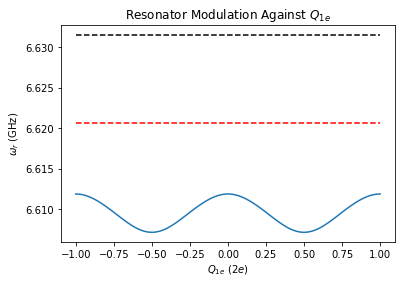

In [70]:
plt.plot(x,Eres[0,0])
plt.plot([x[0], x[-1]], [fr, fr], "k--")
plt.plot([x[0], x[-1]], [frl, frl], "r--")
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$\omega_{r}$ (GHz)")
plt.title("Resonator Modulation Against $Q_{1e}$")

The fact that the resonator frequency is pulled downwards is understood, since the energy gap is always larger than the resonator energy here. We also seem to get a decent modulation depth, about 10 MHz for the given coupling capacitance of 5 fF.

### DC-SQUID Device

Now we replace the single junction with a two junctions of the same size as before, again assuming perfect symmetry.

In [71]:
# Set the parameter values
hamil.setParameterValues(
    'Q1e', 0.0,
    'wse', 0.2,
)

# Configure the sweep
hamil.newSweep()
hamil.addSweep('phie', -0.4999, 0.4999, 101)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('Resonator', cpl_node=1)

# Do the sweep
sweep = hamil.paramSweep(timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.022 s
  Loop duration:	2.900 s
  Avg iteration:	0.029 s


Text(0.5, 1.0, 'Ground State')

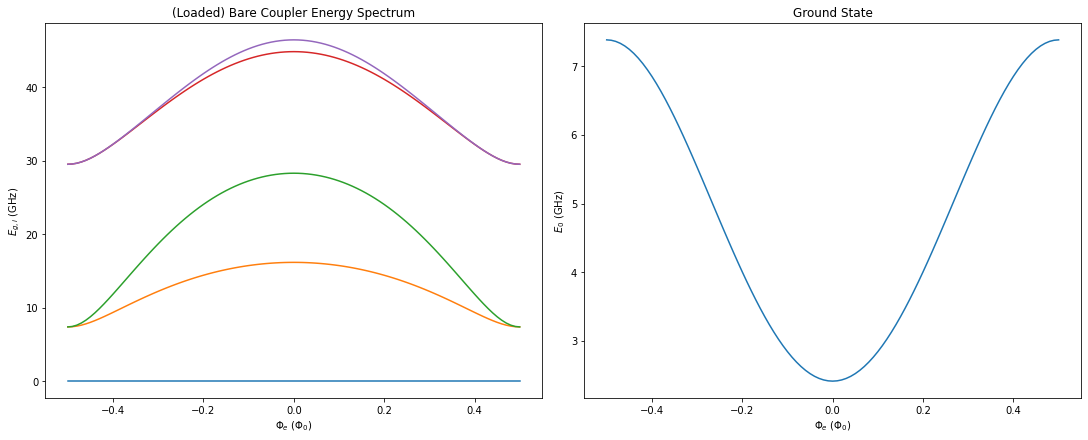

In [72]:
x,EV,v = hamil.getSweep(sweep,'phie',{},evaluable='Hamiltonian')
E = EV[:,0]
V = EV[:,1]

fig, ax = plt.subplots(ncols=2,nrows=1,constrained_layout=True,figsize=(15,6))
ax1 = ax[0]
ax2 = ax[1]

# Energy spectrum
for i in range(5):
    y = E[i]-E[0]
    ax1.plot(x,y)
ax1.set_xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
ax1.set_ylabel("$E_{g,i}$ (GHz)")
ax1.set_title("(Loaded) Bare Coupler Energy Spectrum")

# Ground state
y = E[1]
ax2.plot(x,y)
ax2.set_xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
ax2.set_ylabel("$E_{0}$ (GHz)")
ax2.set_title("Ground State")

In [73]:
x, Erwa, v = hamil.getSweep(sweep, 'phie', {}, evaluable='Resonator')

# Get the design and loaded resonator frequencies
fr = hamil.getParameterValue('f1r')
frl = hamil.getParameterValue('f1rl')

# Get the modulated resonator frequency
Eres = util.getResonatorShift(Erwa)

Text(0.5, 1.0, 'Resonator Modulation Against $\\Phi_{e}$ at $Q_{1e}=0$')

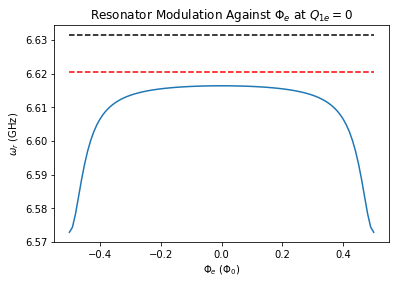

In [74]:
plt.plot(x,Eres[0,0])
plt.plot([x[0], x[-1]], [fr, fr], "k--")
plt.plot([x[0], x[-1]], [frl, frl], "r--")
plt.xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}$ (GHz)")
plt.title("Resonator Modulation Against $\\Phi_{e}$ at $Q_{1e}=0$")

In [75]:
# Set the parameter values
hamil.setParameterValues(
    'Q1e', 0.5
)

hamil.newSweep()
hamil.addSweep('phie', -0.4999, 0.4999, 101)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('Resonator', cpl_node=1)

# Do the sweep
sweep = hamil.paramSweep(timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.025 s
  Loop duration:	2.725 s
  Avg iteration:	0.027 s


Text(0.5, 1.0, 'Ground State')

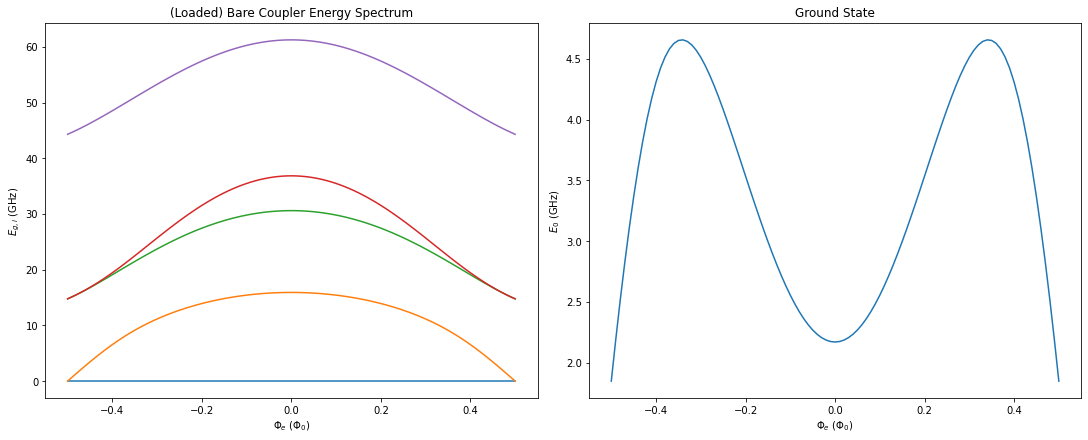

In [76]:
x,EV,v = hamil.getSweep(sweep,'phie',{},evaluable='Hamiltonian')
E = EV[:,0]
V = EV[:,1]

fig, ax = plt.subplots(ncols=2,nrows=1,constrained_layout=True,figsize=(15,6))
ax1 = ax[0]
ax2 = ax[1]

# Energy spectrum
for i in range(5):
    y = E[i]-E[0]
    ax1.plot(x,y)
ax1.set_xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
ax1.set_ylabel("$E_{g,i}$ (GHz)")
ax1.set_title("(Loaded) Bare Coupler Energy Spectrum")

# Ground state
y = E[1]
ax2.plot(x,y)
ax2.set_xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
ax2.set_ylabel("$E_{0}$ (GHz)")
ax2.set_title("Ground State")

Text(0.5, 1.0, 'Resonator Modulation Against $\\Phi_{e}$ at $Q_{1e}=e$')

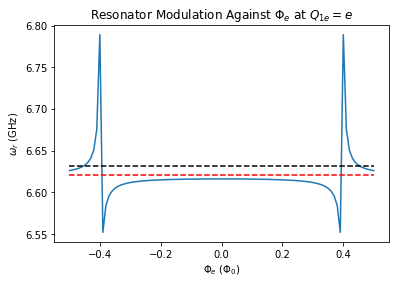

In [77]:
x,Erwa,v = hamil.getSweep(sweep,'phie',{},evaluable='Resonator')

# Get the design and loaded resonator frequencies
fr = hamil.getParameterValue('f1r')
frl = hamil.getParameterValue('f1rl')

# Get the modulated resonator frequency
Eres = util.getResonatorShift(Erwa)

plt.plot(x,Eres[0,0])
plt.plot([x[0], x[-1]], [fr, fr], "k--")
plt.plot([x[0], x[-1]], [frl, frl], "r--")
plt.xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}$ (GHz)")
plt.title("Resonator Modulation Against $\\Phi_{e}$ at $Q_{1e}=e$")